# NNet class in Pytorch

Versions:

* 3.2: *RMSE in example output of `generate_k_fold_cross_validation_sets` are corrected. `A3grader.zip` updated.*
* 3.1: *`A3grader.zip` is now available.  The `generate_k_fold_cross_validation_sets` function had an error that is fixed in this version.*

* 3.0: *`A3grader.zip` is not available yet.*

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` function.

In [2]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):

            #. . .
            Y = self(X)
            mse_func = torch.nn.MSELoss()
            mse = mse_func(T, Y)
            mse.backward()
            optimizer.step() 
            optimizer.zero_grad()
            #TODO: is unstandardizing with T right?
            self.error_trace = mse * self.Tstds + self.Tmeans
            
            unstd = mse
            unstd = mse.detach().numpy()
            unstd = np.sqrt(unstd)
            unstd = unstd * self.Tstds.detach().numpy()
            if verbose == True and (epoch + 1 is n_epochs or (epoch + 1) % (n_epochs //10) == 0):
                print("Epoch " + str(epoch + 1) + f': RMSE {unstd[0]:.3f}')

    def use(self, X):
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        
        # Standardize X
        #. . .
        X = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        #. . .
        Y = self(X)
        Y = Y * self.Tstds + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.detach().numpy()


## Example

In [3]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5: RMSE 11.155
Epoch 10: RMSE 6.062
Epoch 15: RMSE 5.169
Epoch 20: RMSE 2.103
Epoch 25: RMSE 2.317
Epoch 30: RMSE 2.636
Epoch 35: RMSE 1.463
Epoch 40: RMSE 1.137
Epoch 45: RMSE 1.170
Epoch 50: RMSE 0.922
RMSE 0.867


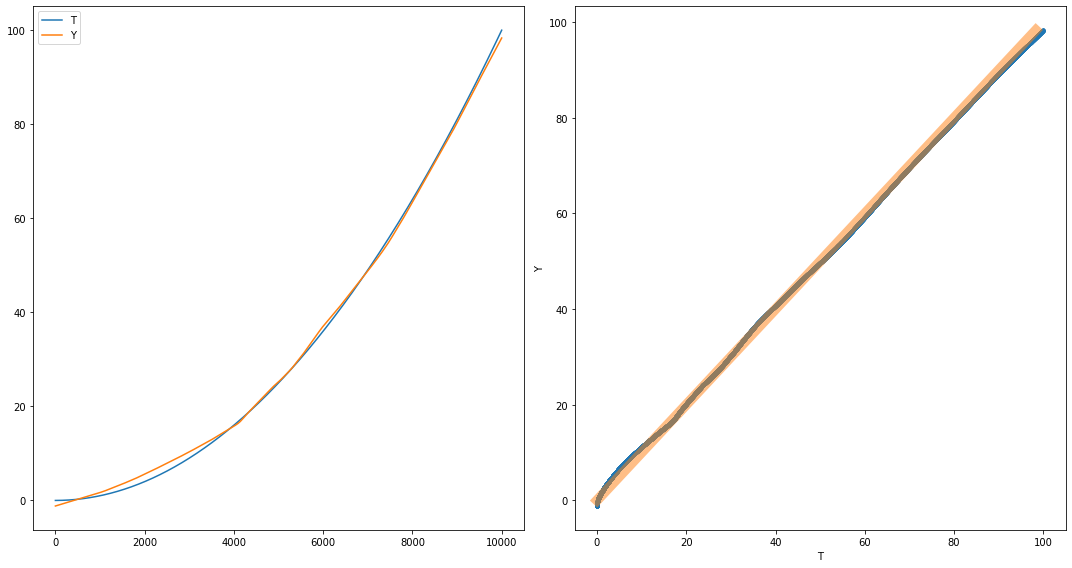

In [4]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [5]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [6]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]), array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [7]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [8]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func):
    
    #. . .
    results = []
    for hidden_layers in list_of_n_hiddens:
        sub_result = [hidden_layers]
        train_rmse_list = []
        validate_rmse_list = []
        test_rmse_list = []
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):
            #TODO: should this be X.shape or Xtrain, etc .shape?
            net = NNet(Xtrain.shape[1], hidden_layers, Ttrain.shape[1], act_func)
            net.train(Xtrain, Ttrain, n_epochs, learning_rate)

            train_rmse = rmse(Ttrain, net.use(Xtrain))
            if train_rmse is float('nan'):
                print("train nan")
            train_rmse_list.append(train_rmse)

            validate_rmse = rmse(Tvalidate, net.use(Xvalidate))
            if validate_rmse is float('nan'):
                print("validate nan")
            validate_rmse_list.append(validate_rmse)
            
            test_rmse = rmse(Ttest, net.use(Xtest))
            if test_rmse is float('nan'):
                print("test nan")
            test_rmse_list.append(test_rmse)

        sub_result.append(np.mean(train_rmse))
        sub_result.append(np.mean(validate_rmse))
        sub_result.append(np.mean(test_rmse))
        results.append(sub_result)

    df = pandas.DataFrame(results, columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))
        
    return df

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [9]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described with at least 10 sentences.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [10]:
X = airfoil.iloc[:,:-1]
X = np.array(X).reshape(1503, 5)
T = airfoil.iloc[:,-1]
T = np.array(T).reshape(1503, 1)

In [11]:
X.shape, T.shape

((1503, 5), (1503, 1))

In [12]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Epoch 20: RMSE 7.087
Epoch 40: RMSE 6.108
Epoch 60: RMSE 5.547
Epoch 80: RMSE 5.201
Epoch 100: RMSE 5.016
Epoch 120: RMSE 4.925
Epoch 140: RMSE 4.884
Epoch 160: RMSE 4.866
Epoch 180: RMSE 4.859
Epoch 200: RMSE 4.856
Epoch 20: RMSE 7.673
Epoch 40: RMSE 6.211
Epoch 60: RMSE 5.391
Epoch 80: RMSE 5.036
Epoch 100: RMSE 4.914
Epoch 120: RMSE 4.882
Epoch 140: RMSE 4.876
Epoch 160: RMSE 4.875
Epoch 180: RMSE 4.875
Epoch 200: RMSE 4.875
Epoch 20: RMSE 7.476
Epoch 40: RMSE 6.274
Epoch 60: RMSE 5.516
Epoch 80: RMSE 5.109
Epoch 100: RMSE 4.915
Epoch 120: RMSE 4.834
Epoch 140: RMSE 4.804
Epoch 160: RMSE 4.795
Epoch 180: RMSE 4.792
Epoch 200: RMSE 4.792
Epoch 20: RMSE 5.085
Epoch 40: RMSE 4.812
Epoch 60: RMSE 4.789
Epoch 80: RMSE 4.771
Epoch 100: RMSE 4.763
Epoch 120: RMSE 4.760
Epoch 140: RMSE 4.758
Epoch 160: RMSE 4.758
Epoch 180: RMSE 4.758
Epoch 200: RMSE 4.758
Epoch 20: RMSE 5.740
Epoch 40: RMSE 5.014
Epoch 60: RMSE 4.866
Epoch 80: RMSE 4.854
Epoch 100: RMSE 4.854
Epoch 120: RMSE 4.854
Epoch 14

,Arch,Train RMSE,Validate RMSE,Test RMSE
0,[],4.679763,5.092106,4.919568
1,[1],4.524104,4.320187,4.437563
2,[5],4.273902,4.173114,4.454635
3,"[200, 200]",1.194468,1.896503,1.665792


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [13]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

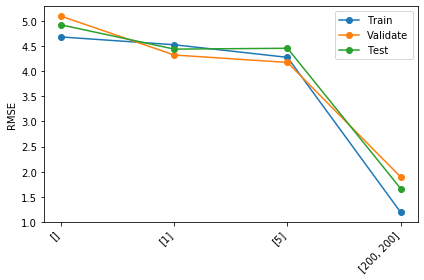

In [14]:
plot_results(results)

In [15]:
#test 1
torch.manual_seed(42)

import time
start = time.time()

airfoil_results = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 20: RMSE 7.067
Epoch 40: RMSE 6.070
Epoch 60: RMSE 5.516
Epoch 80: RMSE 5.173
Epoch 100: RMSE 4.987
Epoch 120: RMSE 4.895
Epoch 140: RMSE 4.852
Epoch 160: RMSE 4.833
Epoch 180: RMSE 4.825
Epoch 200: RMSE 4.821
Epoch 20: RMSE 7.838
Epoch 40: RMSE 6.353
Epoch 60: RMSE 5.499
Epoch 80: RMSE 5.107
Epoch 100: RMSE 4.963
Epoch 120: RMSE 4.921
Epoch 140: RMSE 4.912
Epoch 160: RMSE 4.910
Epoch 180: RMSE 4.910
Epoch 200: RMSE 4.910
Epoch 20: RMSE 7.410
Epoch 40: RMSE 6.182
Epoch 60: RMSE 5.419
Epoch 80: RMSE 5.021
Epoch 100: RMSE 4.845
Epoch 120: RMSE 4.779
Epoch 140: RMSE 4.757
Epoch 160: RMSE 4.752
Epoch 180: RMSE 4.750
Epoch 200: RMSE 4.750
Epoch 20: RMSE 5.127
Epoch 40: RMSE 4.851
Epoch 60: RMSE 4.823
Epoch 80: RMSE 4.798
Epoch 100: RMSE 4.787
Epoch 120: RMSE 4.781
Epoch 140: RMSE 4.779
Epoch 160: RMSE 4.778
Epoch 180: RMSE 4.778
Epoch 200: RMSE 4.777
Epoch 20: RMSE 5.672
Epoch 40: RMSE 4.970
Epoch 60: RMSE 4.830
Epoch 80: RMSE 4.819
Epoch 100: RMSE 4.819
Epoch 120: RMSE 4.818
Epoch 14

In [16]:
#test 2
torch.manual_seed(42)

import time
start = time.time()

airfoil_results2 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 200, 0.01, 'relu')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 20: RMSE 7.021
Epoch 40: RMSE 6.045
Epoch 60: RMSE 5.524
Epoch 80: RMSE 5.211
Epoch 100: RMSE 5.047
Epoch 120: RMSE 4.969
Epoch 140: RMSE 4.933
Epoch 160: RMSE 4.918
Epoch 180: RMSE 4.911
Epoch 200: RMSE 4.908
Epoch 20: RMSE 8.024
Epoch 40: RMSE 6.396
Epoch 60: RMSE 5.450
Epoch 80: RMSE 5.019
Epoch 100: RMSE 4.864
Epoch 120: RMSE 4.821
Epoch 140: RMSE 4.812
Epoch 160: RMSE 4.811
Epoch 180: RMSE 4.811
Epoch 200: RMSE 4.811
Epoch 20: RMSE 7.700
Epoch 40: RMSE 6.374
Epoch 60: RMSE 5.530
Epoch 80: RMSE 5.075
Epoch 100: RMSE 4.864
Epoch 120: RMSE 4.781
Epoch 140: RMSE 4.753
Epoch 160: RMSE 4.746
Epoch 180: RMSE 4.744
Epoch 200: RMSE 4.743
Epoch 20: RMSE 5.228
Epoch 40: RMSE 4.957
Epoch 60: RMSE 4.930
Epoch 80: RMSE 4.910
Epoch 100: RMSE 4.903
Epoch 120: RMSE 4.900
Epoch 140: RMSE 4.900
Epoch 160: RMSE 4.899
Epoch 180: RMSE 4.899
Epoch 200: RMSE 4.899
Epoch 20: RMSE 5.694
Epoch 40: RMSE 5.038
Epoch 60: RMSE 4.915
Epoch 80: RMSE 4.907
Epoch 100: RMSE 4.907
Epoch 120: RMSE 4.906
Epoch 14

In [17]:
#test 3
torch.manual_seed(42)

import time
start = time.time()

airfoil_results3 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 500, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 50: RMSE 5.846
Epoch 100: RMSE 5.109
Epoch 150: RMSE 4.978
Epoch 200: RMSE 4.961
Epoch 250: RMSE 4.958
Epoch 300: RMSE 4.958
Epoch 350: RMSE 4.958
Epoch 400: RMSE 4.958
Epoch 450: RMSE 4.958
Epoch 500: RMSE 4.958
Epoch 50: RMSE 5.858
Epoch 100: RMSE 4.915
Epoch 150: RMSE 4.870
Epoch 200: RMSE 4.869
Epoch 250: RMSE 4.869
Epoch 300: RMSE 4.869
Epoch 350: RMSE 4.869
Epoch 400: RMSE 4.869
Epoch 450: RMSE 4.869
Epoch 500: RMSE 4.869
Epoch 50: RMSE 5.704
Epoch 100: RMSE 4.790
Epoch 150: RMSE 4.700
Epoch 200: RMSE 4.697
Epoch 250: RMSE 4.697
Epoch 300: RMSE 4.697
Epoch 350: RMSE 4.697
Epoch 400: RMSE 4.697
Epoch 450: RMSE 4.697
Epoch 500: RMSE 4.697
Epoch 50: RMSE 4.888
Epoch 100: RMSE 4.850
Epoch 150: RMSE 4.845
Epoch 200: RMSE 4.845
Epoch 250: RMSE 4.845
Epoch 300: RMSE 4.845
Epoch 350: RMSE 4.845
Epoch 400: RMSE 4.845
Epoch 450: RMSE 4.845
Epoch 500: RMSE 4.845
Epoch 50: RMSE 5.006
Epoch 100: RMSE 4.958
Epoch 150: RMSE 4.958
Epoch 200: RMSE 4.958
Epoch 250: RMSE 4.958
Epoch 300: RMSE

In [18]:
#test 4
torch.manual_seed(42)

import time
start = time.time()

airfoil_results4 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 500, 0.01, 'relu')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 50: RMSE 5.860
Epoch 100: RMSE 5.114
Epoch 150: RMSE 4.968
Epoch 200: RMSE 4.945
Epoch 250: RMSE 4.941
Epoch 300: RMSE 4.941
Epoch 350: RMSE 4.941
Epoch 400: RMSE 4.941
Epoch 450: RMSE 4.941
Epoch 500: RMSE 4.941
Epoch 50: RMSE 5.900
Epoch 100: RMSE 4.922
Epoch 150: RMSE 4.859
Epoch 200: RMSE 4.858
Epoch 250: RMSE 4.858
Epoch 300: RMSE 4.858
Epoch 350: RMSE 4.858
Epoch 400: RMSE 4.858
Epoch 450: RMSE 4.858
Epoch 500: RMSE 4.858
Epoch 50: RMSE 5.800
Epoch 100: RMSE 4.831
Epoch 150: RMSE 4.730
Epoch 200: RMSE 4.726
Epoch 250: RMSE 4.726
Epoch 300: RMSE 4.726
Epoch 350: RMSE 4.726
Epoch 400: RMSE 4.726
Epoch 450: RMSE 4.726
Epoch 500: RMSE 4.726
Epoch 50: RMSE 4.953
Epoch 100: RMSE 4.915
Epoch 150: RMSE 4.911
Epoch 200: RMSE 4.911
Epoch 250: RMSE 4.911
Epoch 300: RMSE 4.911
Epoch 350: RMSE 4.911
Epoch 400: RMSE 4.911
Epoch 450: RMSE 4.911
Epoch 500: RMSE 4.911
Epoch 50: RMSE 4.995
Epoch 100: RMSE 4.941
Epoch 150: RMSE 4.941
Epoch 200: RMSE 4.941
Epoch 250: RMSE 4.941
Epoch 300: RMSE

In [19]:
#test 5
torch.manual_seed(42)

import time
start = time.time()

airfoil_results5 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 1000, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 100: RMSE 5.053
Epoch 200: RMSE 4.856
Epoch 300: RMSE 4.851
Epoch 400: RMSE 4.851
Epoch 500: RMSE 4.851
Epoch 600: RMSE 4.851
Epoch 700: RMSE 4.851
Epoch 800: RMSE 4.851
Epoch 900: RMSE 4.851
Epoch 1000: RMSE 4.851
Epoch 100: RMSE 4.984
Epoch 200: RMSE 4.939
Epoch 300: RMSE 4.939
Epoch 400: RMSE 4.939
Epoch 500: RMSE 4.939
Epoch 600: RMSE 4.939
Epoch 700: RMSE 4.939
Epoch 800: RMSE 4.939
Epoch 900: RMSE 4.939
Epoch 1000: RMSE 4.939
Epoch 100: RMSE 4.838
Epoch 200: RMSE 4.731
Epoch 300: RMSE 4.731
Epoch 400: RMSE 4.731
Epoch 500: RMSE 4.731
Epoch 600: RMSE 4.731
Epoch 700: RMSE 4.731
Epoch 800: RMSE 4.731
Epoch 900: RMSE 4.731
Epoch 1000: RMSE 4.731
Epoch 100: RMSE 4.776
Epoch 200: RMSE 4.772
Epoch 300: RMSE 4.772
Epoch 400: RMSE 4.772
Epoch 500: RMSE 4.772
Epoch 600: RMSE 4.772
Epoch 700: RMSE 4.772
Epoch 800: RMSE 4.772
Epoch 900: RMSE 4.772
Epoch 1000: RMSE 4.772
Epoch 100: RMSE 4.851
Epoch 200: RMSE 4.851
Epoch 300: RMSE 4.851
Epoch 400: RMSE 4.851
Epoch 500: RMSE 4.851
Epoch 

In [20]:
#test 6
torch.manual_seed(42)

import time
start = time.time()

airfoil_results6 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 1000, 0.01, 'relu')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 100: RMSE 4.828
Epoch 200: RMSE 4.665
Epoch 300: RMSE 4.662
Epoch 400: RMSE 4.661
Epoch 500: RMSE 4.661
Epoch 600: RMSE 4.661
Epoch 700: RMSE 4.661
Epoch 800: RMSE 4.661
Epoch 900: RMSE 4.661
Epoch 1000: RMSE 4.661
Epoch 100: RMSE 4.752
Epoch 200: RMSE 4.688
Epoch 300: RMSE 4.687
Epoch 400: RMSE 4.687
Epoch 500: RMSE 4.687
Epoch 600: RMSE 4.687
Epoch 700: RMSE 4.687
Epoch 800: RMSE 4.687
Epoch 900: RMSE 4.687
Epoch 1000: RMSE 4.687
Epoch 100: RMSE 4.833
Epoch 200: RMSE 4.732
Epoch 300: RMSE 4.732
Epoch 400: RMSE 4.732
Epoch 500: RMSE 4.732
Epoch 600: RMSE 4.732
Epoch 700: RMSE 4.732
Epoch 800: RMSE 4.732
Epoch 900: RMSE 4.732
Epoch 1000: RMSE 4.732
Epoch 100: RMSE 4.789
Epoch 200: RMSE 4.783
Epoch 300: RMSE 4.783
Epoch 400: RMSE 4.783
Epoch 500: RMSE 4.783
Epoch 600: RMSE 4.783
Epoch 700: RMSE 4.783
Epoch 800: RMSE 4.783
Epoch 900: RMSE 4.783
Epoch 1000: RMSE 4.783
Epoch 100: RMSE 4.662
Epoch 200: RMSE 4.661
Epoch 300: RMSE 4.661
Epoch 400: RMSE 4.661
Epoch 500: RMSE 4.661
Epoch 

In [21]:
#test 7
torch.manual_seed(42)

import time
start = time.time()

airfoil_results7 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 2000, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 200: RMSE 4.672
Epoch 400: RMSE 4.670
Epoch 600: RMSE 4.670
Epoch 800: RMSE 4.670
Epoch 1000: RMSE 4.670
Epoch 1200: RMSE 4.670
Epoch 1400: RMSE 4.670
Epoch 1600: RMSE 4.670
Epoch 1800: RMSE 4.670
Epoch 2000: RMSE 4.670
Epoch 200: RMSE 4.798
Epoch 400: RMSE 4.797
Epoch 600: RMSE 4.797
Epoch 800: RMSE 4.797
Epoch 1000: RMSE 4.797
Epoch 1200: RMSE 4.797
Epoch 1400: RMSE 4.797
Epoch 1600: RMSE 4.797
Epoch 1800: RMSE 4.797
Epoch 2000: RMSE 4.797
Epoch 200: RMSE 4.715
Epoch 400: RMSE 4.714
Epoch 600: RMSE 4.714
Epoch 800: RMSE 4.714
Epoch 1000: RMSE 4.714
Epoch 1200: RMSE 4.714
Epoch 1400: RMSE 4.714
Epoch 1600: RMSE 4.714
Epoch 1800: RMSE 4.714
Epoch 2000: RMSE 4.714
Epoch 200: RMSE 4.812
Epoch 400: RMSE 4.812
Epoch 600: RMSE 4.812
Epoch 800: RMSE 4.812
Epoch 1000: RMSE 4.812
Epoch 1200: RMSE 4.812
Epoch 1400: RMSE 4.812
Epoch 1600: RMSE 4.812
Epoch 1800: RMSE 4.812
Epoch 2000: RMSE 4.812
Epoch 200: RMSE 4.670
Epoch 400: RMSE 4.670
Epoch 600: RMSE 4.670
Epoch 800: RMSE 4.670
Epoch 10

In [22]:
#test 8
torch.manual_seed(42)

import time
start = time.time()

airfoil_results8 = run_k_fold_cross_validation(X, T, 5, [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]], 2000, 0.01, 'relu')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')

Epoch 200: RMSE 4.686
Epoch 400: RMSE 4.682
Epoch 600: RMSE 4.682
Epoch 800: RMSE 4.682
Epoch 1000: RMSE 4.682
Epoch 1200: RMSE 4.682
Epoch 1400: RMSE 4.682
Epoch 1600: RMSE 4.682
Epoch 1800: RMSE 4.682
Epoch 2000: RMSE 4.682
Epoch 200: RMSE 4.658
Epoch 400: RMSE 4.658
Epoch 600: RMSE 4.658
Epoch 800: RMSE 4.658
Epoch 1000: RMSE 4.658
Epoch 1200: RMSE 4.658
Epoch 1400: RMSE 4.658
Epoch 1600: RMSE 4.658
Epoch 1800: RMSE 4.658
Epoch 2000: RMSE 4.658
Epoch 200: RMSE 4.809
Epoch 400: RMSE 4.809
Epoch 600: RMSE 4.809
Epoch 800: RMSE 4.809
Epoch 1000: RMSE 4.809
Epoch 1200: RMSE 4.809
Epoch 1400: RMSE 4.809
Epoch 1600: RMSE 4.809
Epoch 1800: RMSE 4.809
Epoch 2000: RMSE 4.809
Epoch 200: RMSE 4.784
Epoch 400: RMSE 4.784
Epoch 600: RMSE 4.784
Epoch 800: RMSE 4.784
Epoch 1000: RMSE 4.784
Epoch 1200: RMSE 4.784
Epoch 1400: RMSE 4.784
Epoch 1600: RMSE 4.784
Epoch 1800: RMSE 4.784
Epoch 2000: RMSE 4.784
Epoch 200: RMSE 4.682
Epoch 400: RMSE 4.682
Epoch 600: RMSE 4.682
Epoch 800: RMSE 4.682
Epoch 10

# Results

Using tanh, 200 epochs:
              Arch  Train RMSE  Validate RMSE  Test RMSE
0               []    4.672862       4.984258   5.031873
1              [1]    4.436475       4.818668   4.213769
2              [5]    4.318826       4.406988   4.017345
3       [200, 200]    1.289292       1.855619   1.957241
4  [300, 300, 300]    1.098431       1.786024   2.109321
5  [500, 500, 500]    2.734738       3.556556   3.171519

Using relu, 200 epochs:
              Arch  Train RMSE  Validate RMSE  Test RMSE
0               []    4.729796       4.674835   5.125224
1              [1]    5.074023       4.750027   5.135359
2              [5]    3.508532       3.571344   3.401078
3       [200, 200]    1.218184       1.529599   1.890858
4  [300, 300, 300]    1.452436       2.285226   2.213856
5  [500, 500, 500]    1.241255       1.703023   1.892966
Using tanh, 500 epochs:
              Arch  Train RMSE  Validate RMSE  Test RMSE
0               []    4.598261       4.902643   5.322619
1              

Text(0.5, 0.98, 'relu, 2000 epochs')

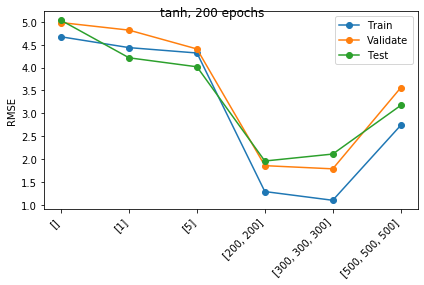

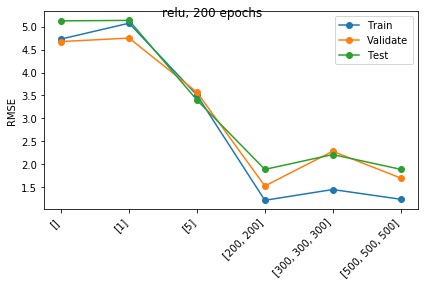

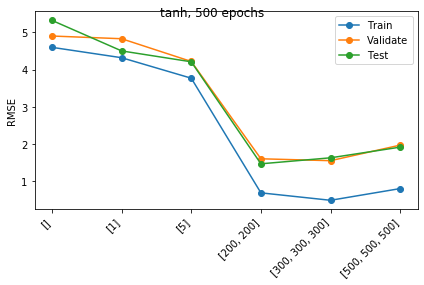

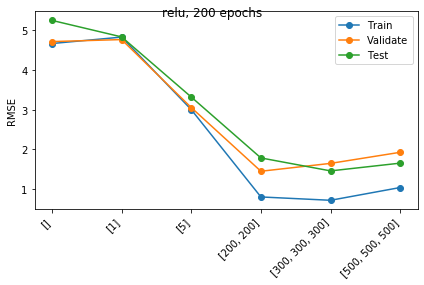

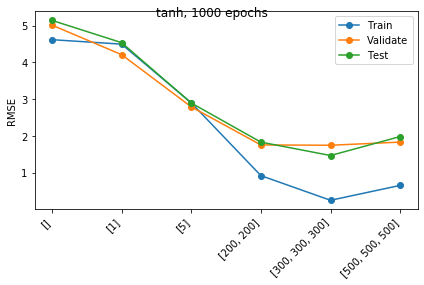

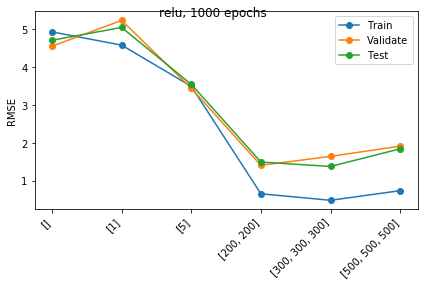

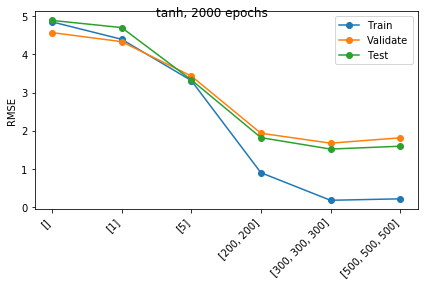

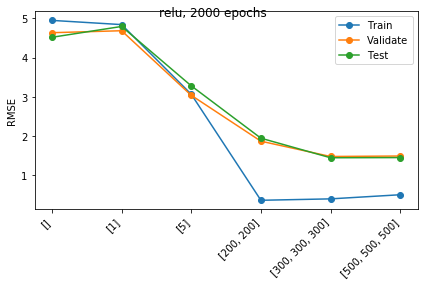

In [23]:
print("Using tanh, 200 epochs:")
print(airfoil_results)
plot_results(airfoil_results)
plt.suptitle('tanh, 200 epochs')

print("\nUsing relu, 200 epochs:")
plt.figure()
plt.clf()
print(airfoil_results2)
plot_results(airfoil_results2)
plt.suptitle('relu, 200 epochs')

print("Using tanh, 500 epochs:")
plt.figure()
plt.clf()
print(airfoil_results3)
plot_results(airfoil_results3)
plt.suptitle('tanh, 500 epochs')

print("Using relu, 500 epochs:")
plt.figure()
print(airfoil_results4)
plot_results(airfoil_results4)
plt.suptitle('relu, 200 epochs')

print("Using tanh, 1000 epochs:")
plt.figure()
print(airfoil_results5)
plot_results(airfoil_results5)
plt.suptitle('tanh, 1000 epochs')

print("Using relu, 1000 epochs:")
plt.figure()
print(airfoil_results6)
plot_results(airfoil_results6)
plt.suptitle('relu, 1000 epochs')

print("Using tanh, 2000 epochs:")
plt.figure()
print(airfoil_results7)
plot_results(airfoil_results7)
plt.suptitle('tanh, 2000 epochs')

print("Using relu, 2000 epochs:")
plt.figure()
print(airfoil_results8)
plot_results(airfoil_results8)
plt.suptitle('relu, 2000 epochs')

# Discussion of Results: 
The hidden layer architectures I used for my tests were: [[], [1], [5], [200, 200], [300, 300, 300], [500, 500, 500]].  I performed tests with 200, 500, 1000 and 2000 epochs, running a test for both the tanh and relu activation functions for each number of epochs and using a learning rate of 0.01.  I found that larger hidden layers generally resulted in a greater difference between the training RMSE and the other RMSE.  I assume that this was because the larger size of the hidden layer allowed the network to more closely memorize the training data, which did not necessarily improve the validation and testing errors very much.  Aside from that, for most of my tests the validation RMSE and the test RMSE were fairly similar.  For the architectures I tested I found that using the relu activation function generally resulted in lower test RMSE than using the tanh activation function, although the difference between the two was not always very large.  I also found that for the epochs I tested, smaller hidden layers such as [200, 200] tended to produce lower test RMSE for smaller amounts of epochs such as 200 or 500.  For higher amounts of epochs such as 1000 or 2000, however, the larger hidden layers such as [300, 300, 300] and [500, 500, 500] produced slightly lower test RMSE than the [200, 200] layer.  I assume this difference would grow larger over time if I ran my tests for even more epochs.  I also observed a large amount of fluctuation of the training, validation and test RMSE in the larger hidden layers for the 200 epoch tests, particularly when using the tanh activation function.  For the range of epochs I tested the architecture with the lowest error was the generally the [300, 300, 300] and [500, 500, 500] hidden layers, once trained for a sufficient amount of epochs.  I observed a 24% decrease in test RMSE using the [500, 500, 500] hidden layer between training for 200 epochs and 2000 epochs.  In conclusion, the architecture that gave me the lowest test RMSE in my testing was the [500, 500, 500] hidden layer using the relu activation function, trained for 2000 epochs using a learning rate of 0.01 and 5 folds.  

# Grading and Check-In

Your notebook will be partially run and graded automatically. Test this grading process by first downloading [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A3grader.zip) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 90/90 if your functions are defined correctly. The remaining 10 points will be based on other testing and the results you obtain and your discussions.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.

For the grading script to run correctly, you must first name this notebook as `Lastname-A3.ipynb`| with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

In [24]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Valdes-A3-Final-Overnight-Rerun.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    


# Extra Credit

Earn up to 2 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.